# Linear and polynomial regression
This note deals mainly with nonlinear modeling and the issue of generalization. These are really two separate and distinct issues in machine learning, but they arise very naturally in contection with each other, and so we choose to introduce there at the same time here. Nonetheless, it is important to also understand that they are different topics, and that generalization issues can arise for any type of classifier (linear or nonlinear), and than nonlinear hypothesis functions are of independent interest.


## Example: Predicting peak electrical power
Suppose you want to predict what the peak electricity demand will be during the day tomorrow for some area (the data is from Pittsburgh). This is actually a very important problem from a logitics planning perspective: electricity generators, which for the most part are based upon boiling water to move turbines, cannot turn on instantly, so in order to guarantee that we have enough power to supply a given area, a system operator typically needs to have some excess generation always waiting in the wings. The better we can forecast future demand, the smaller our excess margin can be, leading to increased efficiency of the entire electrical grid.
The power consumption tomorrow depends on many factors: temperature, day of week, season, holiday events, etc, not to mention some inherrent randomness that we don’t expect to even predict with perfect accuracy. 

What _is_ easy, however, is simply to collect lots of data about past energy
consumption (the system operator serving the Pittsburgh region, PJM, maintains
a data set available [here](http://www.pjm.com/markets-and-operations/ops-analysis/historical-load-data.aspx)) 
as well as the past factors that affect consumption, like the past weather for
the area (which can be easily downloaded from the [WeFacts](http://wefacts.org)). Specifically, we downloaded the `201X-hourly-loads.xls` files for 2013-2017 (and did the preprocessing task the final dataset is in the `temp_demand.csv` file), and the weather for Pittsburgh from 2013-2017 (in the `kpit_weather.csv` file). 


Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
#%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Reading data

In [2]:
df = pd.read_csv("Pittsburgh_load_data.csv", index_col="Date")
df.head()

AVG       MAX       MIN      Total  High_temp  Avg_temp
Date                                                                    
01.01.2013  1.598524  1.859947  0.001599  38.368031        0.0     -1.68
02.01.2013  1.809347  2.054215  0.001809  43.428194       -3.9     -6.58
03.01.2013  1.832822  2.049550  0.001833  43.991607        0.6     -6.12
04.01.2013  1.812699  2.008168  0.001813  43.508609        0.0     -1.95
05.01.2013  1.662036  1.838251  0.001662  39.892360        1.7     -1.47

### Linear regression
A linear regression model is fitted for summer data. 

Plotting the _Peak Demand_ vs. _High Temperature_ during summer. As it can be seen there is a linear relation between peak demand and temperature

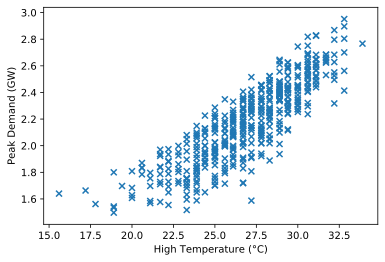

In [3]:
df_summer = df[list(map(lambda x : str(x)[3:5] in ["06", "07", "08"], df.index))].copy()
plt.scatter(df_summer["High_temp"], df_summer["MAX"], marker='x')
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.savefig('peak demand summer.png', dpi = 300)

In [4]:
model = LinearRegression(fit_intercept =True)


In [5]:
model.fit (df_summer["High_temp"].values.reshape(-1,1),df_summer["MAX"])
model_pred = model.predict(df_summer["High_temp"].values.reshape(-1,1))

The scatter plot of Peak demand vs. High temperature and the fitted linear regression:

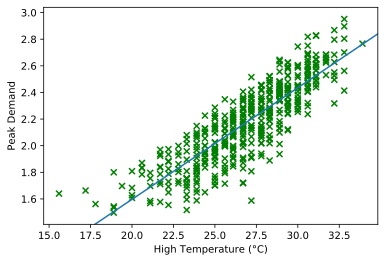

[0.08385936] -0.08024740699315025
The R^2 of linear regression is:  0.7301181597178452


In [6]:
plt.scatter( df_summer["High_temp"] ,df_summer["MAX"], marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
Z = np.linspace(14,35)
T = model.intercept_ + model.coef_*Z
plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand")
plt.show()
print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(df_summer["MAX"], model_pred))

## Nonlinear modeling
The relationship between high temperature and electrical demand is well-modelled by a linear function during the summer months, when (at least in Pittsburgh), electricity in summer is dominated by air conditioners (so with higher temperatures comes higher consumption). However, this is clearly not the case of the entire year. Indeed, if our previous linear model is to be believed then with lower temperatures we would continue to have lower and lower consumption (until, at some point, we’d start generating electricity). Naturally, this is not the case, and if we instead consider the entire year of high temperature and peak dmeand, or average temperature and average demand then another picture emerges.

Notation:

- xp = High temperature 
- yp = Peak demand 
- xa = Average temperature 
- ya = Average demand

In [7]:
xp = df["High_temp"].values
yp = df["MAX"].values
xa = df["Avg_temp"].values
ya = df["AVG"].values

Text(0, 0.5, 'Peak Demand (GW)')

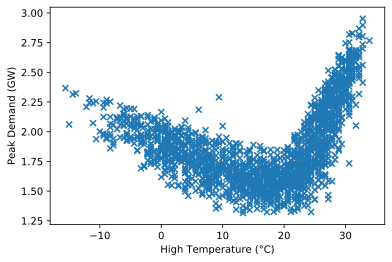

In [8]:
plt.scatter(xp, yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")

This captures the effects we expect. Although peak demand increases sharply with consumption after a high temperature of 22 degrees or so (precisely the range where air conditioning usually starts), below this the demand actually start to increase with lower temperature – though not with as steep a slope, due to the fact, for example, that most heating in Pittsburgh is done with gas rather than with electricity, and other loads that do increase with lower temperatures tend to be smaller in magnitude that air conditions.

#### Linear regression
If we were to fit a linear model to this data, it would look like the following:

The R^2 of linear regression is:  0.09387669129560838


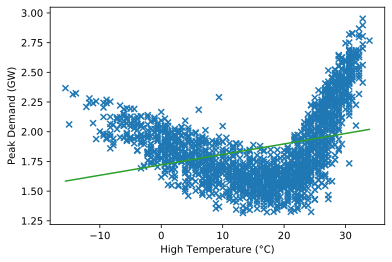

In [9]:
lr = LinearRegression()
lr.fit(xp.reshape(-1,1), yp)
model_pred_p = lr.predict(xp.reshape(-1,1))
plt.scatter(xp, yp, marker="x" )
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.plot(xp, model_pred_p, c='C2')
print ('The R^2 of linear regression is: ',r2_score(yp, model_pred_p))

### Quadratic
To capture data of this type, we clearly want some way of expressing nonlinear relationships in the data.  Fortunately, this is possible without actually leaving the domain of so-called "linear regresion".  The trick we are going to use is a simple one: rather than have features $x^{(i)}$ which only include the "raw" inputs such as temperatuare (plus other raw inputs such as weekday indicators that we saw previously), we are going to make build features that include _nonlinear_ functions of the underlying inputs.  For example, we could choose the following features
\begin{equation}
x^{(i)} = \left [ \begin{array}{c} (\mathrm{HighTemperature}^{(i)})^2 \\
\mathrm{HighTemperature}^{(i)} \\ 1 \end{array} \right ]
\end{equation}
which also include a quadratic function of the high temperature variable.  If we choose this representation, then our linear hypothesis function $h_\theta(x) = \theta^Tx$ is now given by
\begin{equation}
h_\theta(x) = \theta_1 (\mathrm{HighTemperature}^{(i)})^2 + \theta_2 \mathrm{HighTemperature}^{(i)} + \theta_3
\end{equation}
which is a _quadratic_ function of the high temperature.  Importantly, however, the hypothesis function is still a linear function of the parameters, and so the exact same solution methods work as before (including the exact solution), just by passing a different feature matrix.


In [10]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression

def plot_regression_poly(x, y, d):
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
        
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])
    #plt.savefig('all data_reg_'+str(d)+'.png', dpi = 300)


Quadratic regression for peak demand data:

[ 1.19800453 -0.19250338  1.58898561]


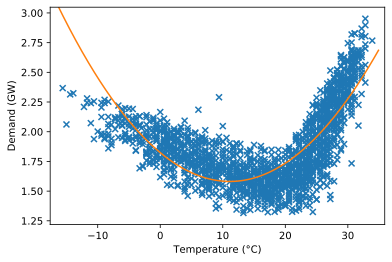

In [11]:
plot_regression_poly(x = xp, y=yp, d = 2)

This looks better, but quadratic function is symmetric around its minimum point, and the data we're trying to fit is definitely not symmetric. Thus, we may want a cubic function.

#### Qubic regression:

[ 1.11163335  0.81686774 -0.59852881  1.64885721]


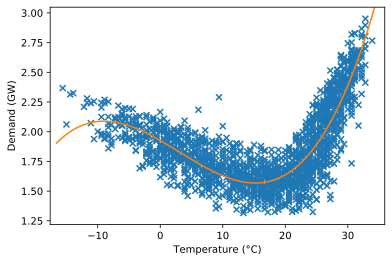

In [12]:
# Plot of Peak demand vs. High temperature
plot_regression_poly(x = xp, y=yp, d = 3)

Still not bad. Let's keep going:

[  436324.59709166 -1139449.23566246   405017.23416319  1102052.25105162]


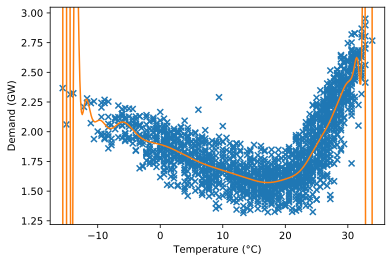

In [13]:
plot_regression_poly(x = xp, y=yp, d = 100)

Something very bad has happened at this point. Especially at the tail ends of the data, where the data points are spaced less closely, we start to get very odd patterns for the data. But the important point is that this is actually a very good fit to the data from a least-squares perspective. As you can see from the figure, the lines pass exactly through many of the data point (most obvious on the left hand side of the plot), whereas for the "better" fits we had above, our function didn't pass exactly through those points, so actually suffered more loss. But there is an obvious way in which the degree 100 polynomial fit, despite having lower loss, is actually a worse approximation to the underlying data. This brings us to the second topic of these notes, which is the issue of generlization and overfitting.

In the following first one of the useful python libraries has been introduced for regression task then we continue with generlization and overfitting topic.

### Using scikit-learn library for fitting a polynomial regression

In [14]:

from sklearn.preprocessing import PolynomialFeatures

In [15]:
Q = np.array([[2,3,4], [5,6,7]])
PF = PolynomialFeatures(degree = 2,interaction_only = False, include_bias = True)
Q_Poly = PF.fit_transform(Q.reshape(-1,1))
print(Q_Poly)

[[ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]
 [ 1.  5. 25.]
 [ 1.  6. 36.]
 [ 1.  7. 49.]]


"d" Shows the degree of the polynomial regression line that we want to fit
for our data. "X" and "Y" are our selected data, which are "temperature" and "peak demand" in this example


In [16]:
def plot_Poly_regression(X,Y,d):
    
    poly_reg = PolynomialFeatures (degree = d)
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_Poly.coef_)

The R^2 for quadratic curve is:  0.6267579638799439


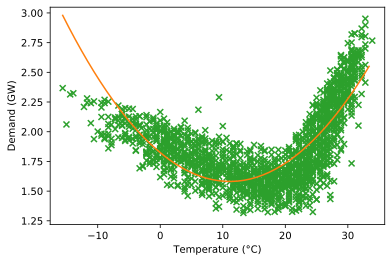

In [17]:
plot_Poly_regression(X = xp, Y = yp, d = 2)

### Cubic


The R^2 for quadratic curve is:  0.7399831142166242


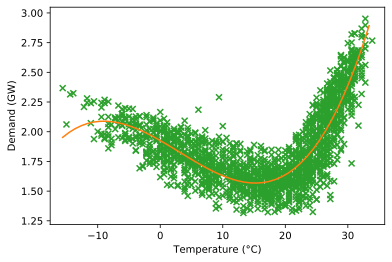

In [18]:
plot_Poly_regression(X = xp, Y = yp,d = 3)

This looks better except for the low end, so maybe one more degree

The R^2 for quadratic curve is:  0.3170265277978508


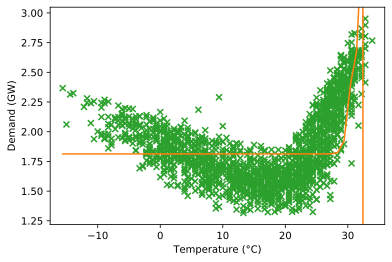

In [19]:
plot_Poly_regression(X = xp, Y = yp,d = 100)

Let's check what is the effect of normalization of features on our nonlinear model.
Polynomial modeling function for normalized data:

In [20]:
def plot_regression_poly_norm(X,Y,d):
    #Normalizing features:
    #min_X, max_X = X.min(), X.max()
    #X_norm = 2*(X - min_X)/(max_X - min_X) - 1
    
    # Polynomial model:
    poly_reg = PolynomialFeatures (degree = d)
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    
    lin_reg_2 = LinearRegression(normalize = True)
    lin_reg_2.fit(x_poly, Y)
    model_pred = lin_reg_2.predict(x_poly)
    
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_2.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_2.coef_)


The R^2 for quadratic curve is:  0.6267579638799439


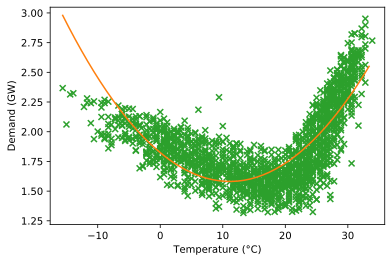

In [21]:
plot_regression_poly_norm(X = xp,Y = yp ,d = 2)

The R^2 for quadratic curve is:  0.7560971384483841


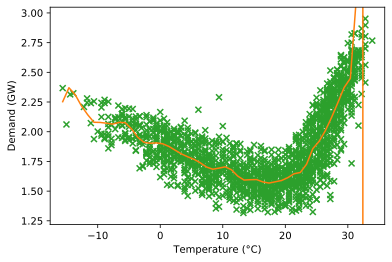

In [22]:
plot_regression_poly_norm(X = xp,Y = yp ,d = 100)

## Generalization and overfitting

Recall from our previous discussions that the canoncial machine learning problem that we solve with every algorithm is the following
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right)
\end{equation}
i.e., to minimize the sum of losses on the data set.  However, in a more fundamental way, this is not really our goal.  We ultimately do not care about achieving low loss specifically on the points that we are feeding into the algorithm: we already _know_ the true output for each of these data points, and if we want to "predict" these points precisely, we could just look up each point in a database (assuming we have some way of referring to the points uniquely).  What we _really_ want from a machine learning algorithm is the ability to predict will on _new_ data points _of the same type_ as those we learned our model on.  We don't care about knowing was the peak demand _was_ on previous days we have already seen; we care about being able to predict what the peak demand will _be_ tomorrow given the high temperature as input.

**Generalization error** This discussion leads us to the notion of _generalization error_.  Informally, the generalization error is just the error (or more generally, the loss) we would experience not on the training data itself, but on new data drawn from the "same distirbution" as the training data.  _This_ is really the quantity we want to minimize, not the error on the training data itself.  Because when we run our machine learning algorithm on new data, all that will matter is its generalization performance.

What the above example illustrated was an instance of _overfitting_, the situation where the training error is low, but the generalization error is high.  This occurs because we are explicitly trying to minimize the loss on the training set, and if the expressiveness of of hypothesis function is small enough, then we can make this loss arbitrarily small, usually by fitting to pecularities in the training data that provide no real benefit when looking at new data.

### Cross validation

The idea of cross validation is simple.  Given the entirety of our training data, we take some fixed percentage, say 70% of the data, and call this our "new" training set.  We then take the remaining data (30% in this case), and call it the _holdout_ or _validation_ set.  The basic idea is that we will use the emprical error or loss on this holdout set as an approximation for the generalization error.  This works because, unlike the training set, we do _not_ choose the parameters of the model based upon the validation set.  This means that there is no way for the parameters to overfit to this data, and thus the validation set still provides a reasonable estimate of generalization error even _after_ the parameters have been trained.

Let's see how to generate these training and validation sets.

In [23]:
X = np.array([df["High_temp"].values, np.ones(len(df))]).T
np.random.seed(10)
perm = np.random.permutation(X.shape[0])
idx_train = perm[:int(len(perm)*0.7)]
idx_cv = perm[int(len(perm)*0.7):]

x_train, y_train = df["High_temp"].iloc[idx_train].values, df["MAX"].iloc[idx_train].values
x_cv, y_cv = df["High_temp"].iloc[idx_cv].values, df["MAX"].iloc[idx_cv].values

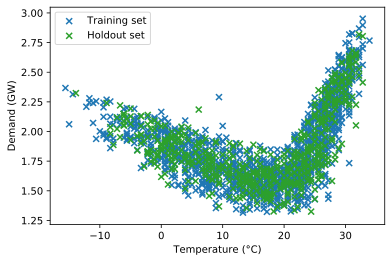

In [24]:
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_cv, y_cv, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])
#plt.savefig('crossvalidation.png', dpi = 300)

Now let’s generate features for the training and cross validation sets. The standard procedure here is that we should compute all feature normalization based upon the training set alone, and only afterwards apply this same normalization to the test set. Note that in some cases it is permissable to include cross validation data points (obviously not the labels) into the normalization process (namely if you expect to have similar access to all the “unlabled” data you will be evaluating the system on prior to training the system), but it’s much more standard to simply use just the new training set for everything, including normalization.

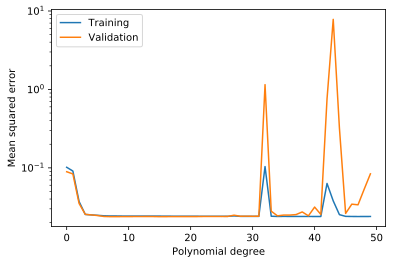

In [25]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_cv = 2*(x_cv - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y)  


err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_cv,i) @ theta - y_cv)**2).mean())
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
plt.savefig('crossvalidation error .png', dpi = 500)

Don't worry about the little increases in training loss at the high end of the figure: these result from numerical instabilities that occur as you have polynomials that that high a degree (simply put, at this range the numerical accuracy of double precision is not high enough). But the point here is hopefully clear, that as model complexity rises, training error decreses (modul numerical stability), while cross validation error can increase greatly (notice we are using a log scale for the plot). But it's also worth emphasizing that this is not a monotonic process: again due to peculiarities in the data, the cross validation loss can jump around significantly. You want to pay more attention to the general tread instead of any particular value of the loss.

So which model is the "best" fit to the data. This is a somewhat subjective question, since it likely involves some combination of a model with low cross-validation error and some subjective notion about preferring "simpler" models all else being equal. Let's look more closely at the range of low loss.

Text(0, 0.5, 'Mean squared error')

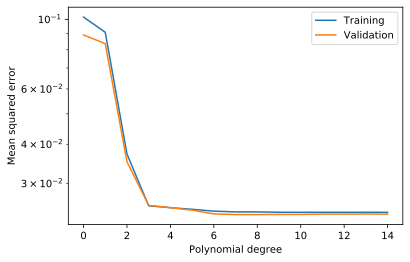

In [26]:
plt.semilogy(range(15), err_train[:15], range(15), err_cv[:15])
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

Looking at the plot, maybe a polynomial degree somewhere between six and eight looks like it has the lowest cross validation error.  Though it would also be reasonable, I think, to advocate for a polynomial of degree three, as the loss sharpely decreases up until this point, and then only improves to a minor degree afterwards, so we may want to prefer the simplicity of the degree three polynomial.


### Cross validation using Scikit-learn library

Scikit-Learn library has built-in function for splitting the dataset into training and holdout set.

In [27]:
#from sklearn.cross_validation import train_test_split


In [28]:
# split the data with 50% in each set
#X_train, X_test, y_train, y_test = train_test_split(xp, yp, random_state=0, train_size=0.7)

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
# split the data with 70% in each set
X_train, X_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3)

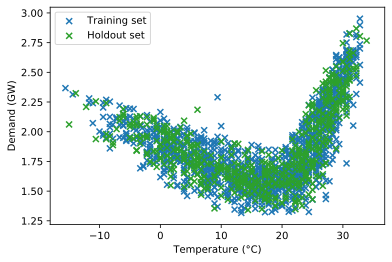

In [31]:
plt.scatter(X_train, y_train, marker='x', color="C0")
plt.scatter(X_test, y_test, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])

In [32]:
# fit the model on one set of data

poly_reg = PolynomialFeatures (degree = 6)
x_poly = poly_reg.fit_transform(X_train.reshape(-1,1))

model = LinearRegression(normalize = True)
model.fit(x_poly, y_train)

# evaluate the model on the second set of data
y_pred = model.predict(poly_reg.fit_transform(X_test.reshape(-1,1)))
print ('The R^2 for quadratic curve is: ',r2_score(y_test, y_pred))


The R^2 for quadratic curve is:  0.7527613304711627


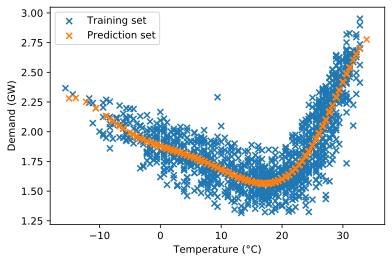

In [33]:
plt.scatter(X_train, y_train, marker='x', color="C0")
plt.scatter(X_test, y_pred, marker='x', color="C1")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Prediction set'])

## Regularization

We have so far seen that the degree of the polynomial we use for our nonlinear features acts as a nice characterization of the model complexity.  But there is another notion of model complexity that is also important to understand, the _magnitude_ of the model parameters.  To see why this is important, let's look again at our degree 100 polynomial fit to the data.

Let's also look at the actual weights involved with this fit.

[  436324.59709166 -1139449.23566246   405017.23416319  1102052.25105162]


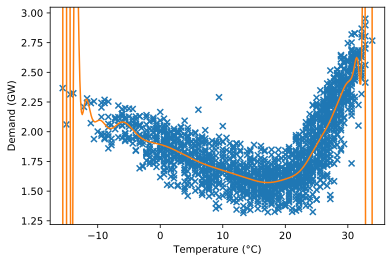

In [34]:
plot_regression_poly(x = xp, y = yp, d = 100)

The way that we get the polynomial to exactly pass through the points requires extremely high values for the coefficients: we need to set the coefficients just so that the different polynomial terms largely “cancel” out precisely at the data points and fit the function exactly to the data.

This also suggests another method for controlling the complexity of the model class: 
restircting the magnitude of the coefficients. This is the basis of the technique known as regularization.

Formally, regularization is often written as an additional term in the canonical machine learning problem.  Instead of simply minimizing the average loss, we minimize the average loss plus a term that penalizes the magnitude of the coefficients (usually some function of a norm of the weights, often just the sum of squared weights also called $\ell_2$ regularization, but other functions are possible as well).  For example, let's consider the following optimizaiton problem:
\begin{equation}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right) + \lambda \sum_{i=1}^n \theta_i^2
\end{equation}
where $\lambda \in \mathbb{R}_+$ is what is called a _regularization parameter_.  $\lambda$ effectively trades off between minimizing the training loss (which naturally "wants" to use large weights), and keeping the weights small.  If $\lambda = 0$, we ignore the regularization term entirely, and just minimize training loss; but as $\lambda \rightarrow \infty$, the _only_ relevant term in the optimization problem becomes the sum of the squared weights, which is clearly minimized if we just pick $\theta = 0$.  Thus, by varying $\lambda$ between zero and some very large constant, we can "sweep out" different ranges of model complexity.

### Visualizing regularization
Let's see what this looks like on our 100 degree polynomial.  The figure above shows the situation with no regularization, i.e, $\lambda = 0$.  If we instead choose $\lambda = 1$, we get the following figure.

In [35]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression
# lam is lambda, the degree of regularization

def plot_regularized_polyregression (x, y, lam, d):
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x) - 1
    #xs = x
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    theta = np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    #xt = xt0 
    xt = 2*(xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
      
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])
    #plt.savefig('all data_Regularised reg_'+str(d)+'.png', dpi = 300)
    
    #return theta
   


[0.00729559 0.0006519  0.0071772  0.00069866]


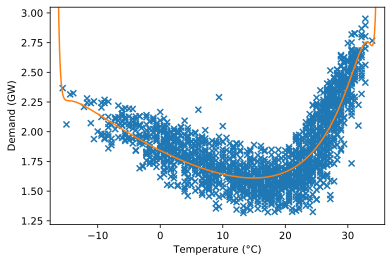

In [36]:
plot_regularized_polyregression (x = xp, y= yp, lam = 10, d = 100)

What happens if we regularize further? As we increase labmda, the underlying function becomes (again, focusing mainly here on the data between the extreme points) looks generally smoother.

[ 0.00578142 -0.02356882  0.00562394 -0.02254179]


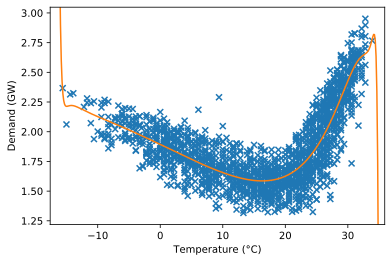

In [37]:
plot_regularized_polyregression (x = xp, y= yp, lam = 1, d = 100)

We can also understand what is happening here by reference to the previous section when we discussed polynomial fittings as a function of the degree of the polynomial.  Remember that after degree 10 or so, there wasn't a huge benefit to including additional polynomial terms in the regression.  Yet, if include these terms within the context of a tradition least squares fit, we have seen that in order to use the polynomial degree to minimize the error (essentially done by "exactly" passing through some of the points), this is accomplished by have very high weight on the high-order coefficients.

So what happens when we apply a regularization penalty?  Because we know that we can achieve low error with a lower-degree polynomial of relatively small weights, if we add sufficient regularization to the optimization objective, this will have the effect of avoiding putting much weight on the high-order terms in the polynomial, and just putting the weight on the lower order terms.  We can view this by looking at the magnitude of the actual coefficients of $\theta$ before and after regularization (remember, $\theta$ is ordered in higher-to-lower degree polynomial terms, so we will flip the order to correspond to increasing degree of the polynomial terms.  First let's look at the magnitude of the coefficients (on a log scale), for the unregularized $\theta$.

In [38]:
def ls_poly_reg(x, y, lam, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)


Text(0, 0.5, 'Coefficient weight')

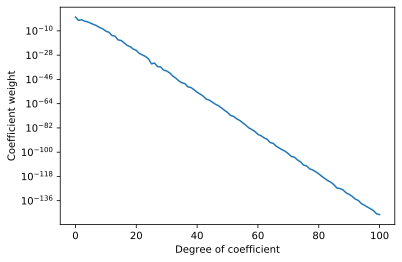

In [39]:
Theta = ls_poly_reg (x = xp, y= yp, lam = 10, degree = 100)
plt.semilogy(range(101), np.abs(Theta[::-1]))
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")


### Regularization using Scikit-learn

#### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization, sometimes also called Tikhonov regularization. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be $$
P = \alpha\sum_{n=1}^N \theta_n^2
$$ where $\alpha$ is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the Ridge estimator:


In [40]:
from sklearn.linear_model import Ridge

Poly = PolynomialFeatures(degree = 6)
X_poly = Poly.fit_transform(xp.reshape(-1,1))

model_L2 = Ridge(alpha = 0.1, normalize = True, solver = 'lsqr')

model_L2.fit(X_poly, yp)
prediction = model_L2.predict(X_poly)

#print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

print ('The R^2 for quadratic curve is: ',r2_score(yp, prediction))

The R^2 for quadratic curve is:  0.7144882463641176


#### Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients: $$
P = \alpha\sum_{n=1}^N |\theta_n|
$$ Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.


In [41]:
from sklearn.linear_model import Lasso

model_L1 = Lasso(alpha = 0.1)

model_L1.fit(X_poly, yp)
predict = model_L1.predict(X_poly)

#print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

print ('The R^2 for quadratic curve is: ',r2_score(yp, predict))

The R^2 for quadratic curve is:  0.7405130050257733


/Users/naserin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Regularization and cross-validation performance

We can also illustrate the effects of regularization as they relate to training and validation performance.  Just as we did with the degree of the polynomial, we can consider the training and validation errors for different amounts of regularization.

Text(0, 0.5, 'Average squared loss')

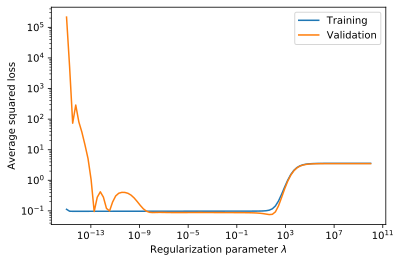

In [42]:
def ls_poly_reg(x, y, lam, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

lam = np.logspace(-15,10,100)

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

phi_train = poly_feat(x_train, 100)
phi_cv = poly_feat(x_cv,100)
err_train = [((phi_train @ ls_poly_reg(x_train, y_train, l, 100) - y_train)**2).mean() for l in lam]
err_cv = [((phi_cv @ ls_poly_reg(x_train, y_train, l, 100) - y_cv)**2).mean() for l in lam]

plt.loglog(lam, err_train, lam, err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Average squared loss")
#plt.savefig('regularization and cross validation.png' , dpi = 300)

A few points are worth emphasizing here.  First, note that this figure looks very similar to the previous one, except that the direction on the x-axis is reversed.  This makes sense due to the nature of the regularization term: lower $\lambda$ means _less_ regularization, whereas large $\lambda$ mean more regularization (eventually just essentially corresponding to all zero weights).  Thus, larger $\lambda$ means _lower_ model complexity, so the x-axis of the figure works in the opposite direction as in the polynomial degree example.  Second, also note that we are using a _logarithmic_ scale on the x-axis (and the y-axis, as before, but the x-axis is the important part here).  This means that regularization typically works on a scale of _orders of magnitude_.  If you search over possible regularization terms, you'll want to do this search over a logarithmic space, because you need very large changes to the magnitude of $\lambda$ to really illustrate the full differences.  Third and last, just as was the case for the polynomial degree, we emphasize that the cross validation error is not a nice unimodal function of $\lambda$; there are multiple local optima owing to the pecularities of the particular polynomial, and it is not easy to globally optimize $\lambda$ by looking at cross validation error in some local region alone.  For this reason, techniques like grid searches are often more common in practice for finding model hyperparamters (including the $\lambda$ term), instead of techniques like gradient-based optimization.

Let's finally zoom in a bit to the "good" region of low cross-validation error.

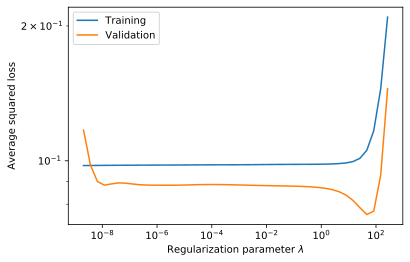

In [43]:
plt.loglog(lam[25:70], err_train[25:70], lam[25:70], err_cv[25:70])
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Average squared loss")
plt.savefig('regularization and cross validation2.png' , dpi = 300)

This plot suggests that regularization parameters between $10^{-2}$ and $10^1$ appear to work best for this problem (I would personally not put much stock in the middle bump between the two extremes, as this is likely an artificat of the particular cross validation set, and the whole range still suffers relatively low error.

## Exercise:

- Fit a polynomial regression model by using scikit-learn library for average temperature and average demand data:
    - Motivate your choice of degree for polynomial features.
    - Split your dataset into test and train set. Evaluate your model on the test set.
    - Examin the effect of regularization. Select a proper value for lambda.
- Plot the data and fitted line. Annotate your graph and size it appropriately.